# Simple Random Network Distillation

### Imports
The first step to using ZnRND is to import the package as you would any other Python library.

In this case we will also import some visualization libraries we can use along the way. Note that, in this case, we have turned off warnings from TF as the very nature of RND, i.e, a lot of re-training, triggers a lot of graph builds and therefore, a lot of TF complaints.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import znrnd 

from flax import linen as nn
import optax
import matplotlib.pyplot as plt
import numpy as np

2022-03-23 15:10:11.820304: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Data pools

In ZnRND we use a data generator to store and handle the passing of data. This makes it easy to perform operations element-wise on data as well as theoretically to make the whole process compilable.

For this example we want to use points on a lattice using a built-in generator.

In [2]:
data_generator = znrnd.data.PointsOnLattice()
data_generator.build_pool(x_points=10, y_points=10)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Just for fun let's look at this data to see what we are working with.

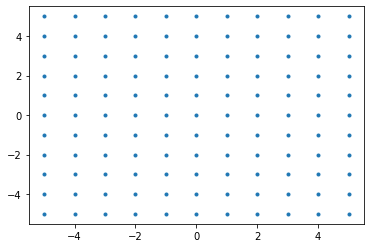

In [3]:
x = data_generator.data_pool[:, 0]
y = data_generator.data_pool[:, 1]

plt.plot(x, y, '.')
plt.show()

So we have some square lattice of points on which to peform distillation. So what will distillation achieve on a grid like this? It should pick points seperated by N lattice spacing depending on what metric we are using.

### Defining the models

Now we need to build our target and predictor models using the build-in ZnRND models.

In [4]:
layer_stack = [nn.Dense(features=12), nn.sigmoid, nn.Dense(features=12), nn.sigmoid, nn.Dense(features=12)]

In [5]:
target = znrnd.models.FlaxModel(
        layer_stack=layer_stack,
        optimizer=optax.sgd(learning_rate=0.001, momentum=0.9),
        loss_fn=znrnd.loss_functions.MeanPowerLoss(order=2),
        input_shape=(2, )
    )

In [6]:
predictor = znrnd.models.FlaxModel(
        layer_stack=layer_stack,
        optimizer=optax.sgd(learning_rate=0.001, momentum=0.9),
        loss_fn=znrnd.loss_functions.MeanPowerLoss(order=2),
        input_shape=(2, )
    )

### Defining the agent

Finally we can define the actualy RND agent which will perform the data selection procedure.

In [7]:
agent = znrnd.RND(
        point_selector=znrnd.point_selection.GreedySelection(threshold=0.00005),
        distance_metric=znrnd.distance_metrics.OrderNDifference(order=2),
        data_generator=data_generator,
        target_network=target,
        predictor_network=predictor,
        tolerance=8,
        target_size=10
    )

### Running rnd

With everything established it is now very simple to run the RND procedure

In [ ]:
agent.run_rnd(visualize=True)

Epoch: 432:  43%|▍| 432/1000 [01:05<01:26,  6.56batch/s, test_loss=1.1

### Visualizing the results

So let's see how well the method performed.

In [ ]:
target_set = np.array(agent.target_set)

x = data_generator.data_pool[:, 0]
y = data_generator.data_pool[:, 1]

x_selected = target_set[:, 0]
y_selected = target_set[:, 1]

plt.plot(x, y, '.', label='Input data')
plt.plot(x_selected, y_selected, 'x', label='Selected Points')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

So we can see that the RND metho was able to pick three points quite far away from one another using these parameters.

### Seeding the process

Sometimes you may know where to start the RND from rather than just randomly selecting a point. We take care of this at the initialization of the RND agent. Let's tell the agent to start with the bottom left corner and center top point in the lattice.

In [ ]:
agent = znrnd.RND(
    point_selector=znrnd.point_selection.GreedySelection(threshold=0.00005),
    distance_metric=znrnd.distance_metrics.OrderNDifference(order=2),
    data_generator=data_generator,
    target_network=target,
    predictor_network=predictor,
    tolerance=8,
    target_size=10,
    seed_point=[[-5, -5], [0, 5]]
    )

In [ ]:
agent.run_rnd()

In [ ]:
target_set = np.array(agent.target_set)

x = data_generator.data_pool[:, 0]
y = data_generator.data_pool[:, 1]

x_selected = target_set[:, 0]
y_selected = target_set[:, 1]

plt.plot(x, y, '.', label='Input data')
plt.plot(x_selected, y_selected, 'x', label='Selected Points')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In this case we have to consider that two of these points are those seeded in the definition of the agent. We can see that in this case, the RND can only find 3 new points each quite far away from one another.